In [19]:
import sys
import numpy as np
import pandas as pd
from fingerprints.get_fp import output, input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
%matplotlib inline

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn import utils


In [47]:
labels_kmeans = pd.read_csv('data/labels_kmeans.csv') # .set_index('CID') commented so X and Y later have same indices
labels_hrc = pd.read_csv('data/labels_hrc.csv').set_index('CID')

kmeans_counts = labels_kmeans.sum().sort_values(ascending=False)
# manual_counts = labels_manual.sum().sort_values(ascending=False)
hierarchical_counts = labels_hrc.sum().sort_values(ascending=False)

print(kmeans_counts, hierarchical_counts)

fingerprint = input

CID          24234111917
cluster_5           1772
cluster_4           1377
cluster_0           1220
cluster_7           1168
cluster_1           1111
cluster_8           1018
cluster_3            896
cluster_2            821
cluster_6            551
dtype: int64 cluster_3    2840
cluster_7    1377
cluster_0    1161
cluster_5     896
cluster_8     821
cluster_1     767
cluster_4     551
cluster_6     403
cluster_2     399
dtype: int64


## kmeans

In [21]:
labels_kmeans = labels_kmeans.drop(labels="CID",axis=1)
labels_kmeans

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0,0,0,0,0,1,0,0,0
1,1,0,1,0,0,0,0,0,1
2,0,1,0,0,0,1,0,0,0
3,0,0,1,0,0,1,0,0,1
4,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
3482,0,0,0,1,0,1,0,0,0
3483,0,1,0,0,0,1,0,0,0
3484,1,1,0,0,1,1,0,0,1
3485,1,1,0,1,1,0,0,0,0


# Splitting the data per cluster
To split the data, we're going to do the test split for each cluster separately and add it together, then shuffle.

In [53]:
labels = pd.read_csv('data/labels.csv')
labels_ = labels.iloc[:, 2:]


In [23]:
y = labels_kmeans
X = fingerprint

# create lists for the training and test set indices
train_indx = set()
test_indx = set()

# loop over all clusters in y and get the train and test indices
# TODO maybe just create the test split and have that be 20% total and taking the rest as the training set??
# So check the percentage of values in each cluster and have the test sets be built up in that ratio too? 
# So having a different test size for different clusters??
for cluster in y.columns:
    cluster_indx = []
    for i in y.index:
        if y.loc[i,cluster] == 1:
            cluster_indx.append(i)
    # create training and test split for the cluster
    train_cluster_indx, test_cluster_indx = train_test_split(cluster_indx, test_size = 0.2, random_state = 12345)
    # check if the indices are already in the other set
    for idx in train_cluster_indx:
        if idx in test_indx or idx in test_cluster_indx:
            train_cluster_indx.remove(idx)
    for idx in test_cluster_indx:
        if idx in train_indx or idx in train_cluster_indx:
            test_cluster_indx.remove(idx)
    # update the training and test indices
    train_indx.update(train_cluster_indx)
    test_indx.update(test_cluster_indx)

# shuffle indices after all cluster indices were added
shuff_train_indx = utils.shuffle(list(train_indx))
shuff_test_indx = utils.shuffle(list(test_indx))

# Get the training and test sets for X and y
y_train = y.iloc[shuff_train_indx,]
y_test = y.iloc[shuff_test_indx,]
X_train = X[shuff_train_indx,]
X_test = X[shuff_test_indx,]

print(f"training set is {len(y_train)} items long and the test set is {len(y_test)} items long")

duplicates = train_indx.intersection(test_indx)
print(len(duplicates))

# The original k-means train_test_split:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

training set is 2942 items long and the test set is 1098 items long
553


# Some duplicate indices in the training and test sets, what to do with those?
There are 472 indexes that are present in both, should they then just be removed from the  test set? 
Doing this gives us a test set that's about 16% of the original data and a training set of 84%.
Idk how sound this is from a methods point of view, but using a test size of 25% and then substracting the duplicates gives us a final test set of 19%. There should be a way to solve the duplicates though I think?

In [61]:
y = np.array(labels_kmeans, dtype=np.float64)
X = fingerprint
X

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [63]:
from skmultilearn.model_selection import iterative_train_test_split


X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.2)
print(f"training set is {len(y_train)} items long and the test set is {len(y_test)} items long")


training set is 2740 items long and the test set is 747 items long


In [64]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 1)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
# m_rf.fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

# print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

ValueError: multiclass-multioutput is not supported

In [ ]:
# m_rf.get_params()

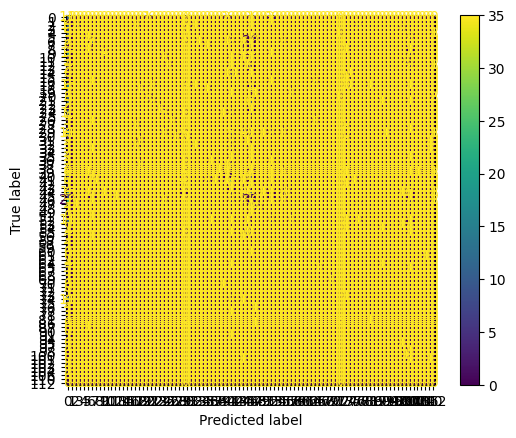

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), y_pred.argmax(axis=1))

## hyperparameter optimisation

In [27]:
# from sklearn.model_selection import StratifiedKFold

# def kfold_cv(X, y, k, H, cv_fun, random_state):
#     """
#     Do stratified k-fold cross-validation with a dataset, to check how a model behaves as a function
#     of the values in H (eg. a hyperparameter such as tree depth, or polynomial degree).

#     :param X: feature matrix.
#     :param y: response column.
#     :param k: number of folds.
#     :param H: values of the hyperparameter to cross-validate.
#     :param cv_fun: function of the form (X_train, y_train, X_valid, y_valid, h) to evaluate the model in one split,
#         as a function of h. It must return a dictionary with metric score values.
#     :param random_state: controls the pseudo random number generation for splitting the data.
#     :return: a Pandas dataframe with metric scores along values in H.
#     """
#     kf = StratifiedKFold(n_splits = k, shuffle = True, random_state = random_state)
#     scores = []  # to store global results

#     # for each value h in H, do CV
#     for h in H:
        
#         # for each fold 1..K
#         kk = 0
#         for train_index, valid_index in kf.split(X, y):
#             kk = kk+1
#             # partition the data in training and validation
#             X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
#             y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

#             # call cv_fun to train the model and compute performance
#             fold_scores = {'_h': h, '_fold': kk}
#             fold_scores.update(cv_fun(X_train, y_train, X_valid, y_valid, h))
#             scores.append(fold_scores)
            
#     return pd.DataFrame(scores)

In [28]:
# functions derived from ...
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

# inlcude max leaf nodes?
def rfc_cv(n_estimators, max_leaf_nodes, x_data, y_targets):
    """Random Forest cross validation.

    This function will instantiate a random forest classifier with parameters
    n_estimators, min_samples_split, and max_depth. Combined with data and
    targets this will in turn be used to perform cross validation. The result
    of cross validation is returned.

    Our goal is to find combinations of n_estimators, min_samples_split, and
    max_depth that minimizes the log loss.
    """
    estimator = RandomForestClassifier(
        n_estimators=n_estimators,
        max_leaf_nodes=max_leaf_nodes,
        random_state=2
    )

    # estimator = MultiOutputClassifier(estimator)
    
    cval = cross_val_score(estimator, x_data, y_targets,
                           scoring='neg_log_loss', cv=4)
    return cval.mean()

In [29]:

def optimize_rfc(x_data, y_targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rfc_crossval(n_estimators, max_leaf_nodes):
        """Wrapper of RandomForest cross validation.
        """
        return rfc_cv(
            n_estimators=int(n_estimators),
            max_leaf_nodes = int(max_leaf_nodes),
            x_data=x_data,
            y_targets=y_targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 750),
            "max_leaf_nodes" : (20, 1000)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)
    return optimizer.max["params"]

In [30]:
best_params = optimize_rfc(X_train, y_train)
# best_params = {'max_depth': 50.21255252823216, 'min_samples_split': 18.30045074432126, 'n_estimators': 232.79840536578715} for multiouptclassiefier
# best_params = {'max_depth': 76.25972013791022, 'max_leaf_nodes': 362.0969729517921, 'min_samples_split': 10.515767360179083, 'n_estimators': 144.68708465574997} for rf
# best_params = {'max_leaf_nodes': 500.0, 'min_samples_split': 2.0, 'n_estimators': 250.0}}
# best_params = {'max_leaf_nodes': 878.4139820472528, 'n_estimators': 255.48761150649477} # best one
# best_params = {'max_leaf_nodes': 536.6351093253395, 'n_estimators': 497.229762171505} 
# best_params = {'max_leaf_nodes': 613.5664151548716, 'n_estimators': 511.18872789561357}



|   iter    |  target   | max_le... | n_esti... |
-------------------------------------------------


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 1         | -5.499    | 207.7     | 470.4     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 2         | -5.453    | 449.0     | 591.2     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 3         | -5.476    | 784.4     | 211.7     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 4         | -5.474    | 290.9     | 603.4     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 5         | -5.503    | 959.0     | 658.2     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 6         | -5.453    | 456.8     | 606.3     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 7         | -5.452    | 595.8     | 480.6     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 8         | -5.601    | 449.6     | 10.59     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 9         | -6.241    | 998.7     | 25.35     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 10        | -5.772    | 20.0      | 10.0      |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 11        | -5.753    | 20.0      | 750.0     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 12        | -5.453    | 557.4     | 256.7     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 13        | -5.459    | 718.4     | 750.0     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 14        | -5.477    | 832.2     | 429.2     |


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


| 15        | -5.467    | 325.2     | 281.2     |
Final result: {'target': -5.451880882072518, 'params': {'max_leaf_nodes': 595.835136062444, 'n_estimators': 480.56474898240555}}


c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [31]:
m_rf = RandomForestClassifier(n_estimators = int(best_params["n_estimators"]), max_features = 1)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.5081967213114754 

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       421
           1       0.88      0.75      0.81       376
           2       0.86      0.62      0.72       270
           3       0.90      0.74      0.81       316
           4       0.88      0.86      0.87       499
           5       0.82      0.83      0.83       601
           6       0.93      0.62      0.75       205
           7       0.86      0.79      0.82       389
           8       0.86      0.75      0.80       347

   micro avg       0.86      0.78      0.82      3424
   macro avg       0.87      0.75      0.81      3424
weighted avg       0.86      0.78      0.81      3424
 samples avg       0.83      0.77      0.77      3424



c:\Users\Ikhlasse\anaconda3\envs\SML\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


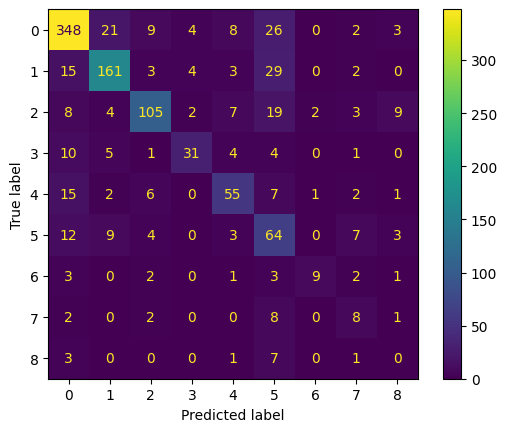

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

## manual

In [33]:
y = labels_manual
X = fingerprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

NameError: name 'labels_manual' is not defined

In [ ]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 3).fit(X_train, y_train)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

print(y_pred)


Accuracy: 0.11031518624641834 

              precision    recall  f1-score   support

           0       0.85      0.69      0.77       363
           1       0.47      0.31      0.37       206
           2       0.69      0.40      0.51       219
           3       0.60      0.33      0.43       202
           4       0.68      0.49      0.57       218
           5       0.69      0.47      0.56       249
           6       0.43      0.11      0.17        55
           7       0.55      0.25      0.35       126
           8       0.59      0.36      0.45       275

   micro avg       0.67      0.44      0.53      1913
   macro avg       0.62      0.38      0.46      1913
weighted avg       0.66      0.44      0.52      1913
 samples avg       0.61      0.46      0.49      1913

[[1 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


C:\Users\jazzs\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


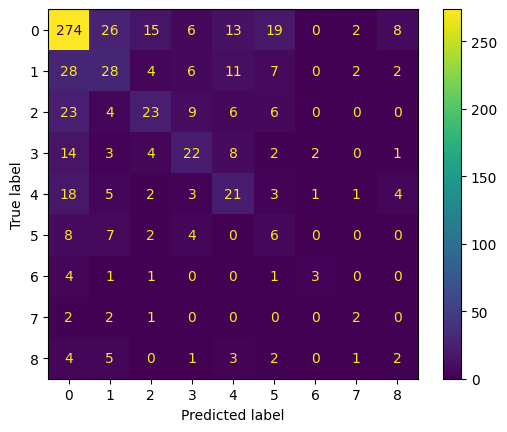

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

## hrc

In [ ]:
y = labels_hrc
X = fingerprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)


In [ ]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 3).fit(X_train, y_train)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.20916905444126074 

              precision    recall  f1-score   support

           0       0.73      0.52      0.60       244
           1       0.72      0.40      0.52       150
           2       0.41      0.09      0.15        76
           3       0.83      0.92      0.87       562
           4       0.59      0.25      0.35       106
           5       0.67      0.32      0.43       177
           6       0.47      0.39      0.43        76
           7       0.81      0.55      0.66       292
           8       0.46      0.20      0.27       148

   micro avg       0.75      0.55      0.64      1831
   macro avg       0.63      0.40      0.48      1831
weighted avg       0.71      0.55      0.60      1831
 samples avg       0.78      0.61      0.64      1831



C:\Users\jazzs\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


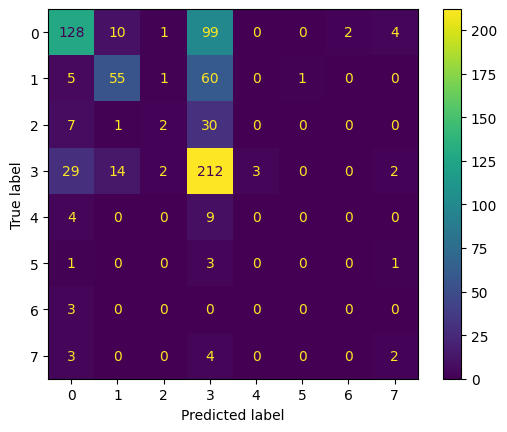

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))